---
title: "ガウス過程と機械学習 3章 ガウス過程回帰"
date: 2024-08-14
categories: [ml,notebook]
---

『ガウス過程と機械学習』 (講談社) の3 章を読んだので、ガウス過程回帰の部分を実際にコードにしてみる。

## 図3.17 の基本アルゴリズムの実装

以下の Qiita 記事の実装を借りて、一部変更した。  
[『ガウス過程と機械学習』Pythonのnumpyだけで実装するガウス過程回帰 #機械学習プロフェッショナルシリーズ - Qiita](https://qiita.com/ogi-iii/items/cf16e13ec09340016121)

注意)この記事のソースコードに「内積はドットで計算」とコメントされている部分があるが、内積ではなく行列積。

In [8]:
import numpy as np

# 元データの作成
n=100
data_x = np.linspace(0, 4*np.pi, n)
data_y = 2*np.sin(data_x) + 3*np.cos(2*data_x) + 5*np.sin(2/3*data_x) + np.random.randn(len(data_x))

# 信号を欠損させて部分的なサンプル点を得る
missing_value_rate = 0.2
sample_index = np.sort(np.random.choice(np.arange(n), int(n*missing_value_rate), replace=False))

# データの定義
xtrain = np.copy(data_x[sample_index])
ytrain = np.copy(data_y[sample_index])

xtest = np.copy(data_x)

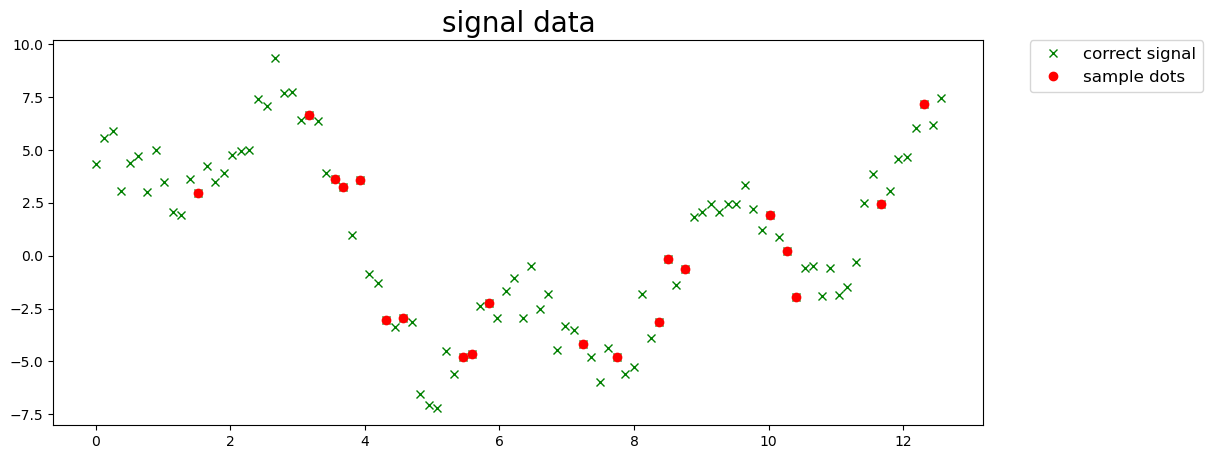

In [9]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 5))
plt.title('signal data', fontsize=20)

# 元の信号
plt.plot(data_x, data_y, 'x', color='green', label='correct signal')

# 部分的なサンプル点
plt.plot(data_x[sample_index], data_y[sample_index], 'o', color='red', label='sample dots')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12)
plt.show()

In [10]:
def RBF(x,x2,theta1,theta2,theta3,i_eq_j=False):
    """RBF kernel"""
    if i_eq_j:
        d=theta3
    else:
        d=0.
    return theta1 * np.exp(-(x-x2)**2/theta2)+d
    

In [11]:
def calc(xtrain,ytrain,xtest,kernel=RBF):
    """ガウス過程回帰の計算 図 3.17"""
    # 平均
    mu = []
    # 分散
    var = []

    # 各パラメータ値
    theta_1 = 1.0
    theta_2 = 0.4
    theta_3 = 0.1

    N = len(xtrain)
    K = np.zeros((N, N))
    
    for x in range(N):
        for x_prime in range(N):
            K[x, x_prime] = kernel(xtrain[x], xtrain[x_prime], theta_1, theta_2, theta_3,x==x_prime)
            
    inv_K=np.linalg.inv(K)
    yy = np.dot(inv_K, ytrain)

    M = len(xtest)
    for test_i in range(M):
        k = np.zeros((N,))
        for x in range(N):
            k[x] = kernel(xtrain[x], xtest[test_i], theta_1, theta_2, theta_3)

        s = kernel(xtest[test_i], xtest[test_i], theta_1, theta_2, theta_3)
        mu.append(np.dot(k, yy))
        kK_ = np.dot(k, inv_K)
        var.append(s - np.dot(kK_, k.T))
    return mu,var


In [12]:
mu,var=calc(xtrain,ytrain,xtest)

In [13]:
def visualize(data_x,data_y,xtest,sample_index,mu,var):
    plt.figure(figsize=(12, 5))
    plt.title('signal prediction by Gaussian process', fontsize=20)
    
    # 元の信号
    plt.plot(data_x, data_y, 'x', color='green', label='correct signal')
    # 部分的なサンプル点
    plt.plot(data_x[sample_index], data_y[sample_index], 'o', color='red', label='sample dots')
    
    # 分散を標準偏差に変換
    std = np.sqrt(var)
    
    # ガウス過程で求めた平均値を信号化
    plt.plot(xtest, mu, color='blue', label='mean by Gaussian process')
    # ガウス過程で求めた標準偏差を範囲化 *範囲に関してはコード末を参照
    plt.fill_between(xtest, mu + 2*std, mu - 2*std, alpha=.2, color='blue', label= 'standard deviation by Gaussian process')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12)
    plt.show()

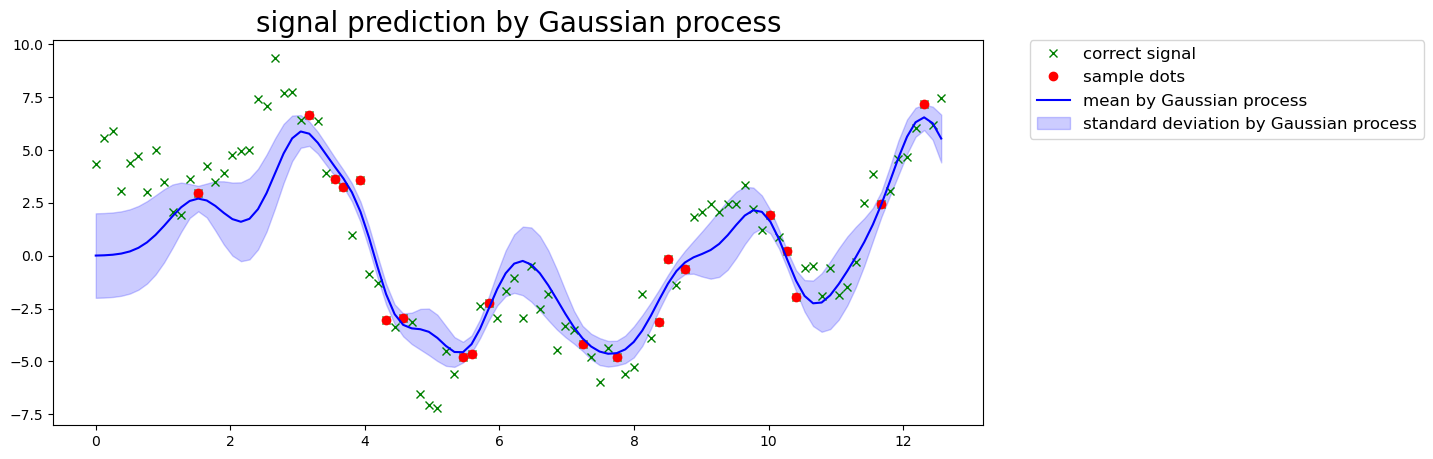

In [14]:
visualize(data_x,data_y,xtest,sample_index,mu,var)

## 行列演算に変更

for 文で処理している箇所を行列の演算に変更する。  
テキスト 図3．18、公式 3.8 あたりを使う。


In [15]:
import numpy.matlib
def kgauss(X,theta_1,theta_2,theta_3):
    """
    図 3.18 の実装
    引数名は上の RBF 関数に合わせた
    """
    N=len(X)
    X=X.reshape(N,-1)
    X=X.T # D * N 次元に
    
    z=(X**2).sum(axis=0).reshape(1,N)
    K = numpy.matlib.repmat(z.T,1,N)+ numpy.matlib.repmat(z,N,1) -np.dot(X.T,X)*2.
    return theta_1*np.exp(-K/theta_2)+theta_3*np.identity(N)

In [16]:
def calc2(xtrain,ytrain,xtest):
    """
    図3.15 や公式 3.8 を使って for文を使わずに計算する
    また、 train データの平均値が 0 でない場合に対応するため、 y の平均値を 0 に正規化してから計算している
    """
    
    # 平均0に正規化する。 y_mu は最後に mu に加算する
    ytrain=ytrain.copy()
    y_mu=ytrain.mean()
    ytrain-=y_mu
  
    # 各パラメータ値
    theta_1 = 1.0
    theta_2 = 0.4
    theta_3 = 0.1

    N = len(xtrain)
    M = len(xtest)
    
    # まとめてカーネル計算
    xtrain=xtrain.reshape(N,-1)
    xtest=xtest.reshape(M,-1)

    # 図3.15 のとおり行列を分割
    X=np.vstack([xtrain, xtest])
    X = kgauss(X,theta_1,theta_2,theta_3)
    
    u, b=np.split(X,[N],0)
    K, k_=np.split(u,[N],1)
    k_t, k__=np.split(b,[N],1)
    
    assert k__.shape==(M,M)

    inv_K=np.linalg.inv(K)
    yy = np.dot(inv_K, ytrain)
    
    mu=np.dot(k_t,yy)
    var=k__-np.dot(np.dot(k_t,inv_K),k_)
    return mu+y_mu, var


In [17]:
mu,var=calc2(xtrain,ytrain,xtest)
var=np.diag(var) # 対角成分の取得
print(mu[:5])
print(var[:5])

[-0.01971533 -0.00715652  0.02049658  0.07619233  0.17859306]
[1.09999167 1.09994689 1.09971164 1.09866746 1.0947585 ]


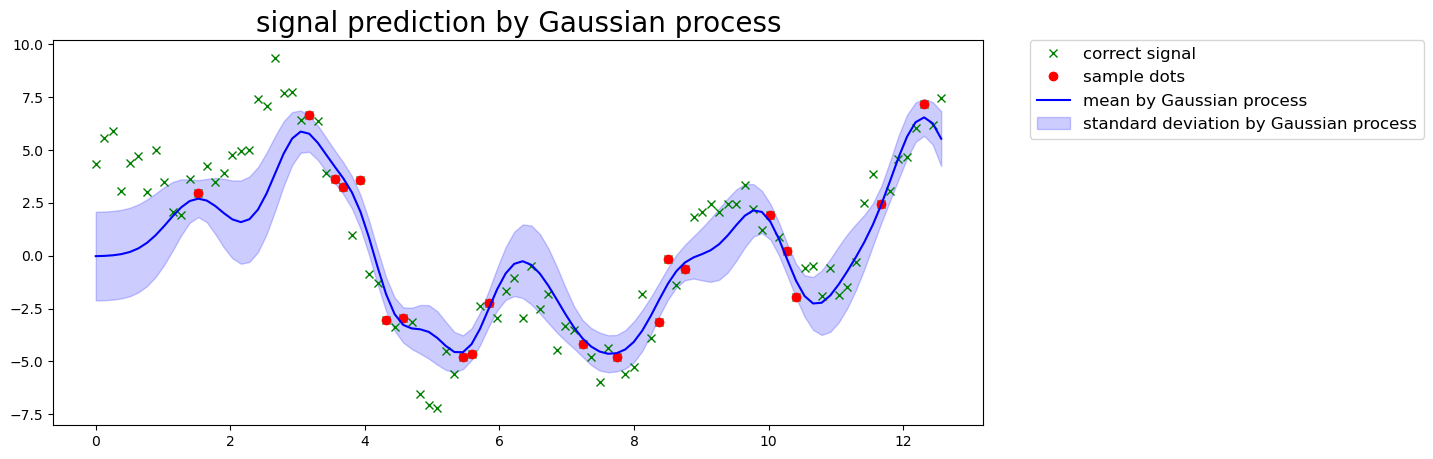

In [18]:
visualize(data_x,data_y,xtest,sample_index,mu,var)

上の結果とほぼ同じ結果が得られている。

### y の平均値が 0 でない場合の確認

テキストに記載あるように、 y の平均値をあらかじめ 0 になるように正規化(？)する処理を加えたので、その確認をする。

In [19]:
# 元データの作成
n=100
data_x = np.linspace(0, 4*np.pi, n)
# 平均 +100 あたりになるように
data_y = 2*np.sin(data_x) + 3*np.cos(2*data_x) + 5*np.sin(2/3*data_x) + np.random.randn(len(data_x)) + 100

missing_value_rate = 0.2
sample_index = np.sort(np.random.choice(np.arange(n), int(n*missing_value_rate), replace=False))

# データの定義
xtrain = np.copy(data_x[sample_index])
ytrain = np.copy(data_y[sample_index])

xtest = np.copy(data_x)

In [20]:
mu,var=calc2(xtrain,ytrain,xtest)
var=np.diag(var)

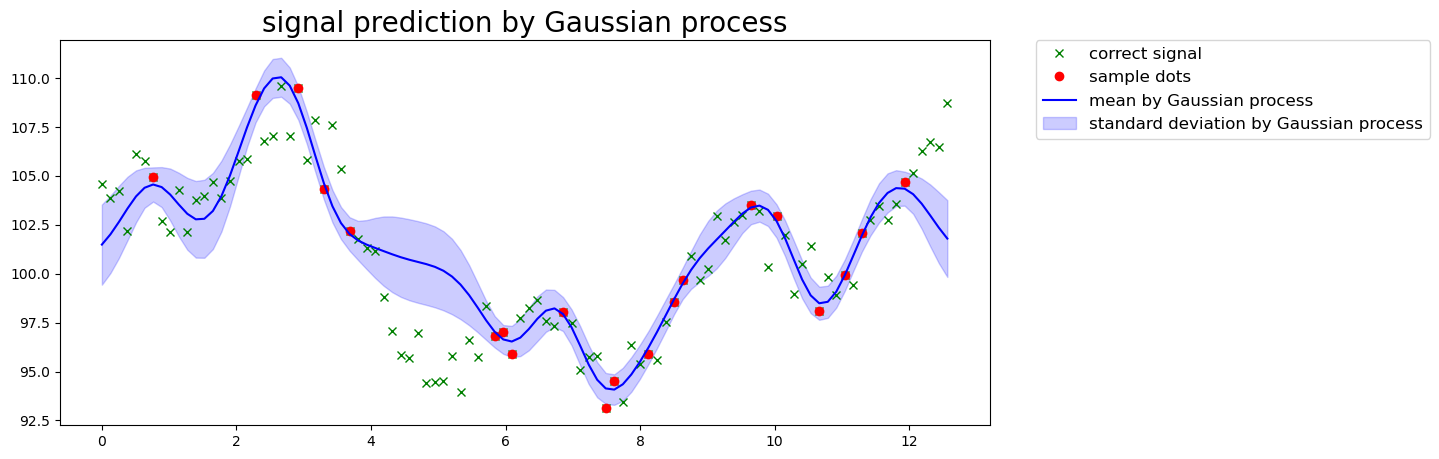

In [21]:
visualize(data_x,data_y,xtest,sample_index,mu,var)

## サンプリングを確認

テキスト 3.2.4

テキストの順番と前後するが、ガウス過程回帰の結果を使ってサンプリング結果も確認しておく。  
求めた平均、分散からランダムにサンプリングして滑らかな関数となる様子を確認する。  
ここで生成される曲線が「事後分布の雲」からランダムに出力された「関数 f」ということになる。

In [25]:

def get_cmap(name='tab10'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.colormaps.get_cmap(name)

def visualize2(data_x,data_y,xtest,sample_index,mu,var,ys):
    plt.figure(figsize=(12, 5))
    plt.title('signal prediction by Gaussian process', fontsize=20)
        
    # ガウス過程で求めた平均値を信号化
    cmap = get_cmap()
    for i,y in enumerate(ys):
        plt.plot(xtest, y, color=cmap(i/len(ys)), label=f'mean by Gaussian process {i}')   
        
    # 元の信号
    plt.plot(data_x, data_y, 'x', color='green', label='correct signal')
    # 部分的なサンプル点
    plt.plot(data_x[sample_index], data_y[sample_index], 'o', color='red', label='sample dots')
    
    # 分散を標準偏差に変換
    std = np.sqrt(var)
    
    # ガウス過程で求めた標準偏差を範囲化 *範囲に関してはコード末を参照
    plt.fill_between(xtest, mu + 2*std, mu - 2*std, alpha=.2, color='blue', label= 'standard deviation by Gaussian process')
    
 
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12)
    plt.show()

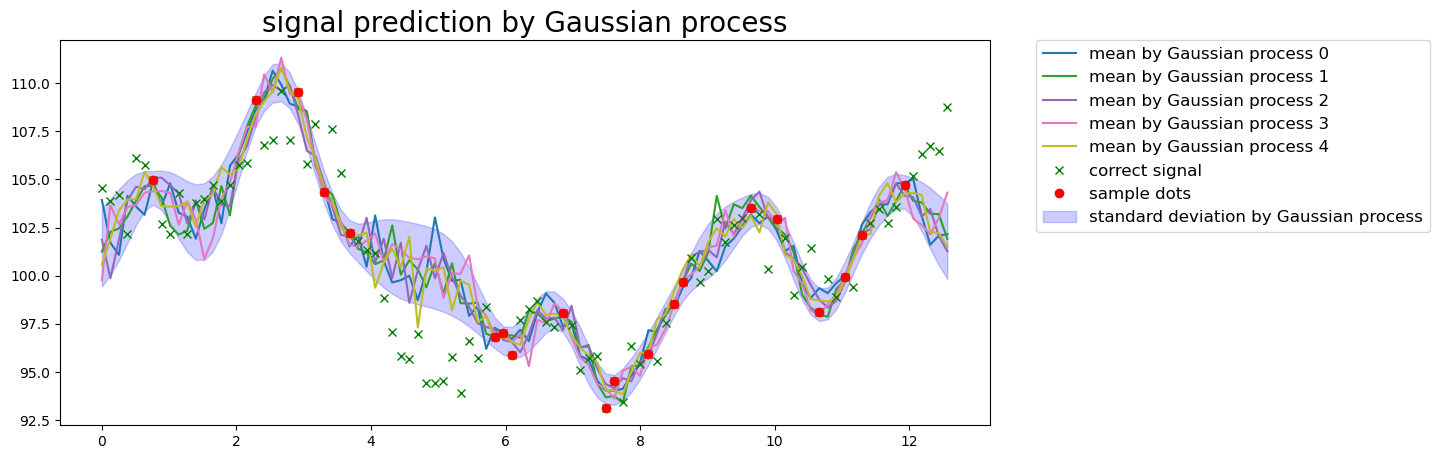

In [26]:
rng = np.random.default_rng()
# 5回のサンプリングを行った結果を表示
ys=[[rng.normal(a,np.sqrt(b)) for a,b in zip(mu,var)] for _ in range(5)]
visualize2(data_x,data_y,xtest,sample_index,mu,var,ys)